In [1]:
# making trajectory visualizations prettier for the actual paper

import torch
import numpy as np
import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf
import yaml

%load_ext autoreload
%autoreload 2
from dysts.flows import Lorenz

import sys

sys.path.append("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings")
from src.models import *
from train import gen_data

In [89]:
# lru path
# path = '/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/multirun/2024-05-18/15-35-39/2'

# gpt path
path = "/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/multirun/2024-05-16/17-47-03/151/"


with open(f"{path}/.hydra/config.yaml") as f:
    cfg = OmegaConf.load(f)

cfg

{'model': {'model_name': 'GPT', 'kwargs': {'input_dim': 1, 'd_model': 100, 'n_head': 10, 'context_length': 500, 'mlp_hidden': 10, 'seed': 10, 'temp': None, 'use_pe': False}}, 'attractor': {'name': 'Lorenz', 'driven_noise': 0.0, 'dt': 0.01, 'observed_noise': 0.05, 'dim_observed': 0, 'resample': False}, 'data': {'time': 500, 'nsamples': 1000, 'batch_size': 10}, 'train': {'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 0.0, 'epochs': 500, 'loss': 'MSE', 'nsteps': 1, 'eval_nsteps': 50, 'schedule': False}, 'eval': {'nstep_eval': {'nsteps': 20, 'n_obs': 4, 'kl_bins': 100, 'spectral_smoothing': 4, 'spectral_cutoff': 200}, 'metrics': ['compute_all_pred_stats', 'eval_nstep', 'neighbors_comparison', 'predict_hidden_dims_lm', 'predict_hidden_dims_mlp', 'noise_amplification'], 'neighbors_comparison': {'n_neighbors': 20}, 'noise_amp': {'k': 3, 'maxT': 10, 'normalize': True}, 'dyn_quants': {'traj_length': 100, 'ntrajs': 10, 'rtol': 0.001, 'atol': 1e-10}, 'predict_hiddens': {'linear_model_kwargs':

In [90]:
epoch = 0
# load model
init_mod = {
    "RNN": RNN,
    "Mamba": Mamba,
    "S4": S4,
    "GPT": GPT,
    "LRU": LRU,
}  # bc eval wasn't working

model = init_mod[cfg.model.model_name](**cfg.model.kwargs)

model.load_state_dict(torch.load(f"{path}/{cfg.model.model_name}_{epoch}.pt"))

<All keys matched successfully>

In [91]:
model.eval()
model

GPT(
  (transformer): ModuleDict(
    (wte): Linear(in_features=1, out_features=100, bias=True)
    (wpe): Embedding(500, 100)
    (h): Block(
      (ln_1): LayerNorm()
      (attn): CausalSelfAttention(
        (qkv): Linear(in_features=100, out_features=300, bias=True)
        (attn_out): Linear(in_features=100, out_features=100, bias=True)
      )
      (attn_out_resid_dummy): Identity()
      (ln_2): LayerNorm()
      (mlp): MLP(
        (c_fc): Linear(in_features=100, out_features=10, bias=True)
        (gelu): GELU(approximate='none')
        (c_proj): Linear(in_features=10, out_features=100, bias=True)
      )
    )
    (out): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [67]:
attractor, loader, data = gen_data(cfg)
data.shape

KeyboardInterrupt: 

In [92]:
dim_observed = cfg.attractor.dim_observed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [93]:
data = data[:, :, dim_observed : dim_observed + 1]

x = data[:, :-1]

x = x.to(device)
y = data[:, 1:].to(device)

y_pred, hiddens = model(x)
hiddens = hiddens.cpu().detach().numpy()
hiddens = np.concatenate([hiddens.real, hiddens.imag], axis=-1)
y_pred.shape, hiddens.shape

(torch.Size([1000, 499, 1]), (1000, 499, 200))

1.1187671


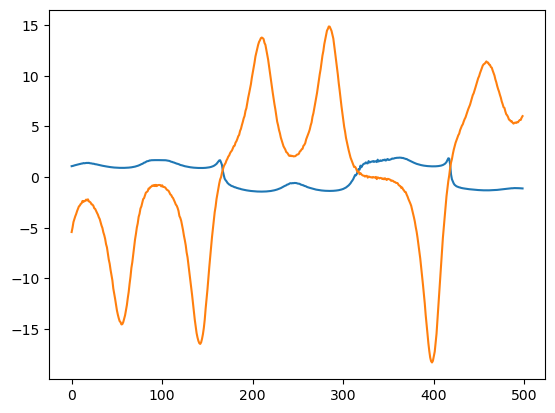

In [94]:
plt.plot(y_pred[0].detach().cpu().numpy(), label="pred")
plt.plot(y[0].detach().cpu().numpy(), label="true")
print(
    np.linalg.norm(y_pred.detach().cpu().numpy() - y.detach().cpu().numpy())
    / np.linalg.norm(y.detach().cpu().numpy())
)

In [95]:
# remove transient
hiddens = hiddens[:, 100:]

In [96]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

pca = PCA(n_components=5)
d = hiddens.reshape(-1, hiddens.shape[-1])
red = pca.fit_transform(d)
print(pca.explained_variance_ratio_)
red = red.reshape(hiddens.shape[0], hiddens.shape[1], 5)

[0.81228898 0.13013003 0.05244955 0.00266979 0.00165157]


Text(0.5, 0.98, 'GPT')

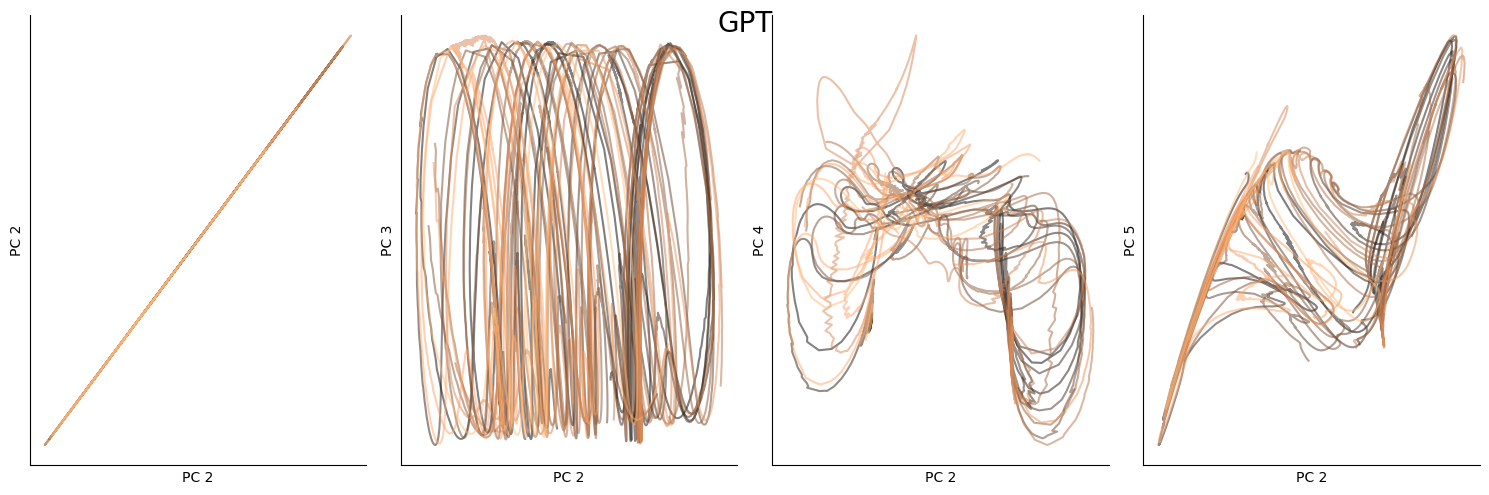

In [98]:
ntrajs = 30

# cmap = cm.bone(np.linspace(0, 1, ntrajs+2))
cmap = cm.copper(np.linspace(0, 1, ntrajs + 2))

npcs = 4

fig, ax = plt.subplots(1, npcs, figsize=(15, 5))
i = 1
ax = ax.reshape(1, npcs)
for j in range(npcs):
    for k in range(ntrajs):
        ax[0, j].plot(red[k, :, i], red[k, :, j + 1], color=cmap[k], alpha=0.5)
    ax[0, j].set_xlabel(f"PC {i+1}")
    ax[0, j].set_ylabel(f"PC {j+2}")
    # ax[0, j].set_xlabel(f"dim {i+1}, EV {pca.explained_variance_ratio_[i]:.4f}")
    # ax[0, j].set_ylabel(f"dim {j+2}, EV {pca.explained_variance_ratio_[j+1]:.4f}")
    # remove top and right lines, as well as ticks
    ax[0, j].spines["top"].set_visible(False)
    ax[0, j].spines["right"].set_visible(False)
    ax[0, j].set_xticks([])
    ax[0, j].set_yticks([])

plt.tight_layout()
plt.suptitle(f"{cfg.model.model_name}", fontsize=20)